# Retinal Scan Classifier
The goal of this project is to build a retinal scan classifier pipeline. The dataset consists of retinal scans alongside a csv file that provides labels for the scans. The retinal scans are labelled either healthy or unhealthy. Furthermore, the retinal scans are also labelled by different eye diseases. Note that an unhealthy eye can have more than one disease. The pipeline is broken up into two stages. Stage 1 is a convolutional neural network binary classifier that attempts to successfully predict whether a retinal scan is healthy or unhealthy. Stage 2 attempts to successfully predict which specific eye diseases are present. There are two different versions of Stage 2. The first version utilizes BinaryRelevance from skmultilearn to train multiple independent convolutional neural network binary classifers (one CNN per disease). This version also utilizes F1 threshold maximization to find the optimal threshold for identifying a disease. The second version is a single convolutional neural network multi-label classifier where the output layer consists of multiple neurons being activated by the sigmoid function to produce probabilities for each disease. Note that for both versions, the input to stage 2 are those scans that are known to be diseased (Disease_Risk = 1).

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/My Drive/dataset.zip" -d "/content/"

Mounted at /content/drive
Archive:  /content/drive/My Drive/dataset.zip
   creating: /content/dataset/
  inflating: /content/dataset/.DS_Store  
  inflating: /content/__MACOSX/dataset/._.DS_Store  
   creating: /content/dataset/Combined_Set/
   creating: /content/dataset/Test_Set/
  inflating: /content/dataset/Combined_Set/labels.csv  
  inflating: /content/__MACOSX/dataset/Combined_Set/._labels.csv  
  inflating: /content/dataset/Combined_Set/.DS_Store  
  inflating: /content/__MACOSX/dataset/Combined_Set/._.DS_Store  
   creating: /content/dataset/Combined_Set/images/
  inflating: /content/dataset/Test_Set/labels.csv  
  inflating: /content/dataset/Test_Set/.DS_Store  
  inflating: /content/__MACOSX/dataset/Test_Set/._.DS_Store  
   creating: /content/dataset/Test_Set/images/
  inflating: /content/dataset/Combined_Set/images/348.png  
  inflating: /content/dataset/Combined_Set/images/1804.png  
  inflating: /content/dataset/Combined_Set/images/1810.png  
  inflating: /content/dataset

In [24]:
import pandas as pd
import os
import shutil
import glob
import gdown
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import math

# View Sample Images

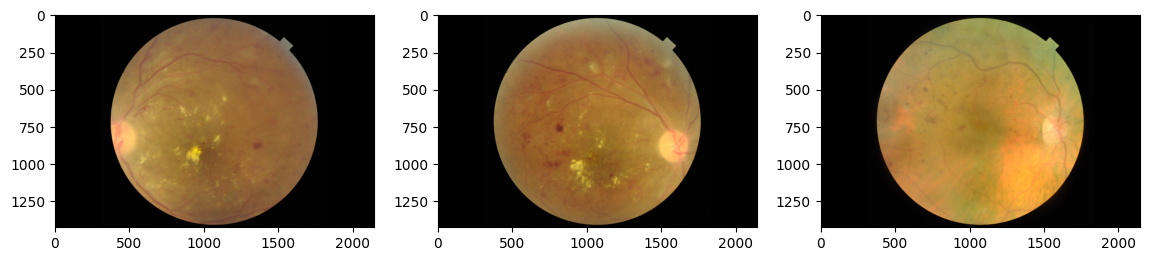

In [25]:
img_1 = Image.open('dataset/Combined_Set/images/1.png')
img_2 = Image.open('dataset/Combined_Set/images/2.png')
img_3 = Image.open('dataset/Test_Set/images/1.png')
plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_1)
plt.subplot(1,3,2)
plt.imshow(img_2)
plt.subplot(1,3,3)
plt.imshow(img_3)
plt.show()

# Two-Stage CNN Pipeline

In [26]:
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from skmultilearn.problem_transform import BinaryRelevance

In [27]:
#Constants
IMG_SIZE = (200, 300)
BATCH_SIZE = 32
SEED = 432

In [28]:
#Loading the dataset and doing preprocessing
def load_dataset(data_path):
    '''
    This function creates a dataframe out of a csv file. It also loads image data and
    their corresponding labels from a specified directory.

    Parameters:
        data_path (str): The root directory where the dataset is stored (i.e., 'dataset/Combined_Set/'
        or 'dataset/Test_Set/')

    Returns:
        df (pandas dataframe): This dataframe consists of the following:

                                An ID columnImage file paths

                                Image File Paths

                                A Disease_Risk column (binary values of 0 or 1)

                                45 disease label columns (binary values of 0 or 1).
    '''
    labels_path = os.path.join(data_path, 'labels.csv')
    images_path = os.path.join(data_path, 'images')
    df = pd.read_csv(labels_path)
    df['file_path'] = df['ID'].astype(str) + '.png'
    df['file_path'] = df['file_path'].apply(lambda x: os.path.join(images_path, x))
    df = df[df['file_path'].apply(os.path.exists)] #Drop missing images
    return df

In [29]:
def preprocess_image(file_path):
    '''
    This function takes the file path of an image and processes it so it's ready for use
    in our neural networks.

    Parameters:
        file_path (str): The path to an image file

    Returns:
        img_array (NumPy array): The image has been resized to IMG_SIZE and the pixel
        values have been normalized to the range 0-1.
    '''
    img = load_img(file_path, target_size=IMG_SIZE)
    img_array = img_to_array(img) / 255.0
    return img_array

# Stage 1: Disease Risk Binary Classifier

In [30]:
#Function to prepare the data
def prepare_stage1_data(df):
    '''
    This function takes in the dataframe from load_dataset and uses the preprocess_image
    function to process the images.

    Parameters:
        df (pandas dataframe): The dataframe that is outputted from load_dataset.

    Returns:
        X (NumPy array): A 4D NumPy array of the image data with shape (num_images, height, width, channels).
        y (NumPy array): The labels which serve as the target variable for the first neural network (Disease_Risk: 0, 1)
        with shape (num_samples,)
    '''
    X = np.array([preprocess_image(image) for image in df['file_path']])
    y = df['Disease_Risk'].values.astype(np.float32)
    return X, y

In [31]:
#Defining the Model
def build_stage1_model(input_shape):
    '''
    This function defines and compiles a Convolutional Neural Network (CNN)
    for binary classification. Namely, Disease_Risk (0 or 1).

    Parameters:
        input_shape (tuple): A tuple specifying the shape of the input images

    Returns:
        model (keras model): The compiled keras model, ready for training with .fit()
    '''
    model = Sequential([
        Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
#Image data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
val_datagen = ImageDataGenerator()

In [57]:
#Train Stage 1 Model (Disease Risk Classifier)
train_df = load_dataset("dataset/Combined_Set")
X1, y1 = prepare_stage1_data(train_df)

X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size=0.2, random_state=SEED)

train_gen = train_datagen.flow(X1_train, y1_train, batch_size=BATCH_SIZE)
val_gen = val_datagen.flow(X1_val, y1_val, batch_size=BATCH_SIZE)

model1 = build_stage1_model((IMG_SIZE[0], IMG_SIZE[1], 3))
history1 = model1.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True),
               ModelCheckpoint('model_stage1.keras', save_best_only=True, monitor='val_loss')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 32s 379ms/step - accuracy: 0.7566 - loss: 1.2731 - val_accuracy: 0.7891 - val_loss: 1.0346
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.7990 - loss: 0.8136 - val_accuracy: 0.7891 - val_loss: 0.8386
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.8199 - loss: 0.6046 - val_accuracy: 0.7891 - val_loss: 0.7108
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.8016 - loss: 0.5360 - val_accuracy: 0.7891 - val_loss: 0.6680
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.8100 - loss: 0.4990 - val_accuracy: 0.7930 - val_loss: 0.6571
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.8137 - loss: 0.4760 - val_accuracy: 0.7930 - val_loss: 0.5737
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 371ms/step - accuracy: 0.8167 - loss: 0.4576 - val_accuracy: 0.7480 - val_loss: 0.6253
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 368ms/step - accuracy: 0.8154 - loss: 0.4577 - val_accu

# Stage 2: Multi-Label Classifier (Binary Relevance)
EDA reveals that multiple diseases have very few positive cases. Thus, we'll drop the rare diseases and focus on predicting the common diseases. We'll also upsample the remaining diseases to ensure that they have at least 500 positive cases.

In [33]:
#Function to prepare the data
def prepare_stage2_data(df):
    '''
    This function prepares a dataset for multi-label classification. That is,
    each image can be associated with multiple disease labels.

    Parameters:
        df (pandas dataframe): The dataframe that is outputted from load_dataset.

    Returns:
        X (NumPy array): A 4D NumPy array of the image data with shape (num_images, height, width, channels).
        y (NumPy array): Multi-label target array (0s and 1s) with shape (num_samples, num_diseases).
        disease_cols (list): A list of containing the names of the diseases.
    '''
    disease_cols = df.columns.tolist()
    #Remove columns that are not disease labels
    non_disease_cols = ['ID', 'file_path', 'Disease_Risk']
    disease_cols = [col for col in disease_cols if col not in non_disease_cols]
    X = np.array([preprocess_image(image) for image in df['file_path']])
    y = df[disease_cols].values.astype(np.float32)
    return X, y, disease_cols

In [34]:
#print value_counts for the 45 disease columns
train_df = load_dataset("dataset/Combined_Set")
disease_cols = train_df.columns.tolist()
non_disease_cols = ['ID', 'file_path', 'Disease_Risk']
disease_cols = [col for col in disease_cols if col not in non_disease_cols]
print("\nValue Counts for Disease Columns:")
for col in disease_cols:
  print()
  print(train_df[col].value_counts())


Value Counts for Disease Columns:

DR
0    2052
1     508
Name: count, dtype: int64

ARMD
0    2422
1     138
Name: count, dtype: int64

MH
0    2141
1     419
Name: count, dtype: int64

DN
0    2376
1     184
Name: count, dtype: int64

MYA
0    2425
1     135
Name: count, dtype: int64

BRVO
0    2464
1      96
Name: count, dtype: int64

TSLN
0    2309
1     251
Name: count, dtype: int64

ERM
0    2539
1      21
Name: count, dtype: int64

LS
0    2496
1      64
Name: count, dtype: int64

MS
0    2540
1      20
Name: count, dtype: int64

CSR
0    2512
1      48
Name: count, dtype: int64

ODC
0    2206
1     354
Name: count, dtype: int64

CRVO
0    2524
1      36
Name: count, dtype: int64

TV
0    2552
1       8
Name: count, dtype: int64

AH
0    2540
1      20
Name: count, dtype: int64

ODP
0    2469
1      91
Name: count, dtype: int64

ODE
0    2481
1      79
Name: count, dtype: int64

ST
0    2551
1       9
Name: count, dtype: int64

AION
0    2538
1      22
Name: count, dtype: int64

In [35]:
#Dropping the rare diseases (from both Combined_Set and Test_Set)
known_risk_df = train_df[train_df['Disease_Risk'] == 1].copy()
#Exclude non-disease columns before summing
disease_cols_only = known_risk_df.drop(columns=['ID', 'file_path', 'Disease_Risk'])
print("\nNumber of columns with at least 100 positive cases:")
print((disease_cols_only.sum() >= 100).sum())


Number of columns with at least 100 positive cases:
7


In [36]:
disease_cols_to_keep = disease_cols_only.columns[disease_cols_only.sum() >= 100].tolist()
known_risk_df = known_risk_df[['ID', 'file_path', 'Disease_Risk'] + disease_cols_to_keep]
print("\nShape of known_risk_df after removing rare diseases:")
print(known_risk_df.shape)
print("\nColumns remaining in known_risk_df:")
print(known_risk_df.columns.tolist())


Shape of known_risk_df after removing rare diseases:
(2025, 10)

Columns remaining in known_risk_df:
['ID', 'file_path', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'TSLN', 'ODC']


In [37]:
#Upsample diseases with less than 500 positive cases
min_positive_cases = 500
disease_cols_upsample = [col for col in disease_cols_to_keep if known_risk_df[col].sum() < min_positive_cases]

upsampled_rows = []
for disease in disease_cols_upsample:
    positive_cases = known_risk_df[known_risk_df[disease] == 1]
    num_upsample = min_positive_cases - len(positive_cases)
    if num_upsample > 0:
        upsampled_rows.append(positive_cases.sample(num_upsample, replace=True, random_state=SEED))

if upsampled_rows:
    upsampled_df = pd.concat(upsampled_rows)
    known_risk_df_upsampled = pd.concat([known_risk_df, upsampled_df]).reset_index(drop=True)
else:
    known_risk_df_upsampled = known_risk_df.copy()

print("\nShape of known_risk_df after upsampling:")
print(known_risk_df_upsampled.shape)

print("\nValue Counts for Disease Columns after upsampling:")
for col in disease_cols_to_keep:
    print()
    print(known_risk_df_upsampled[col].value_counts())


Shape of known_risk_df after upsampling:
(3544, 10)

Value Counts for Disease Columns after upsampling:

DR
0    2957
1     587
Name: count, dtype: int64

ARMD
0    2882
1     662
Name: count, dtype: int64

MH
0    2866
1     678
Name: count, dtype: int64

DN
0    3000
1     544
Name: count, dtype: int64

MYA
0    2941
1     603
Name: count, dtype: int64

TSLN
0    2851
1     693
Name: count, dtype: int64

ODC
0    2827
1     717
Name: count, dtype: int64


In [41]:
#Prepare the data for Stage 2 using the upsampled dataframe
X2_upsampled, y2_upsampled, disease_names = prepare_stage2_data(known_risk_df_upsampled)
print("\nShape of X2:")
print(X2_upsampled.shape)
print("\nShape of y2:")
print(y2_upsampled.shape)
print("\nDisease columns for Stage 2:")
disease_names


Shape of X2:
(3544, 200, 300, 3)

Shape of y2:
(3544, 7)

Disease columns for Stage 2:


['DR', 'ARMD', 'MH', 'DN', 'MYA', 'TSLN', 'ODC']

In [55]:
test_df = load_dataset("dataset/Test_Set")
test_df = test_df[['ID', 'file_path', 'Disease_Risk'] + disease_cols_to_keep]
print("\nShape of test_df after removing rare diseases:")
print(test_df.shape)
print("\nDisease columns remaining in test_df:")
print(test_df.columns.tolist())


Shape of test_df after removing rare diseases:
(640, 10)

Disease columns remaining in test_df:
['ID', 'file_path', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'TSLN', 'ODC']


In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score as sk_f1_score

#Function to find optimal threshold per label
def find_optimal_threshold(y_true, y_probs):
    '''
    Finds the optimal probability threshold for a binary classifier
    to maximize the F1 score.

    Parameters:
        y_true (array): True binary labels (0 or 1).
        y_probs (array): Predicted probabilities (0 to 1).

    Returns:
        optimal_threshold (float): The threshold that yields the highest F1 score.
        optimal_f1 (float): The highest F1 score achieved at the optimal threshold.
    '''
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    if len(thresholds) == 0:
        return 0.5, 0.0 #Default to 0.5 threshold and 0 F1 if no variation
    thresholds = np.append(thresholds, 1.0)
    #Calculate F1 score for each threshold
    f1_scores = []
    for i in range(len(thresholds)):
        y_pred = (y_probs >= thresholds[i]).astype(int)
        f1 = sk_f1_score(y_true, y_pred, zero_division=0)
        f1_scores.append(f1)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    return optimal_threshold, optimal_f1

In [50]:
#KerasBinaryClassifier coded to work with BinaryRelevance from skmultilearn
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.base import clone
class KerasBinaryClassifierWithProbs(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, epochs=10, batch_size=32, class_weight=None):
        self.input_shape = input_shape
        self.epochs = epochs
        self.batch_size = batch_size
        self.class_weight = class_weight
        self.model = None

    def _build_model(self):
        model = Sequential([
            Conv2D(32, (3,3), padding='same', activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            MaxPooling2D(2,2),
            Conv2D(64, (3,3), padding='same', activation='relu'),
            BatchNormalization(),
            MaxPooling2D(2,2),
            GlobalAveragePooling2D(),
            Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
            Dropout(0.5),
            Dense(1, activation='sigmoid')
        ])
        #Use weighted binary crossentropy if class_weight is provided
        loss = tf.keras.losses.BinaryCrossentropy()
        model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])
        return model

    def fit(self, X, y):
        if self.model is None:
             self.model = self._build_model()
        history = self.model.fit(
            X, y,
            epochs=self.epochs,
            batch_size=self.batch_size,
            verbose=0,
            class_weight=self.class_weight
            )
        return self

    def predict_proba(self, X):
        return self.model.predict(X)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

    def get_params(self, deep=True):
        return {
            "input_shape": self.input_shape,
            "epochs": self.epochs,
            "batch_size": self.batch_size,
            "class_weight": self.class_weight
            }

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        if 'input_shape' in params or 'class_weight' in params:
             self.model = None
        return self


#Modified DenseBinaryRelevance to handle threshold optimization
class DenseBinaryRelevanceWithThresholds(BinaryRelevance):
    def fit(self, X, y):
        self._label_count = y.shape[1]
        self.classifiers = []
        self.thresholds = []

        X_train_all, X_val_all, y_train_all, y_val_all = train_test_split(
            X, y, test_size=0.2, random_state=SEED
        )

        for label in range(self._label_count):
            print(f"Training classifier for label {label+1}/{self._label_count} ({disease_names[label]})...")

            y_train_label = y_train_all[:, label]

            try:
                X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
                    X_train_all, y_train_label, test_size=0.25, random_state=SEED, stratify=y_train_label
                )
            except ValueError as e:
                print(f"Warning: Stratification failed for label {disease_names[label]}. Skipping stratification for this label. Error: {e}")
                X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(
                    X_train_all, y_train_label, test_size=0.25, random_state=SEED
                )

            unique_labels, counts = np.unique(y_train_clf, return_counts=True)
            if 1 in unique_labels and 0 in unique_labels:
                 scale_pos_weight = counts[0] / counts[1]
                 class_weight = {0: 1.0, 1: scale_pos_weight}
                 print(f"  Class weights for '{disease_names[label]}': {class_weight}")
            else:
                 class_weight = None
                 print(f"  Warning: Only one class present in training split for '{disease_names[label]}'. Skipping class weighting.")


            #Clone and configure the base classifier
            clf = clone(self.classifier)
            clf.set_params(class_weight=class_weight)
            clf.fit(X_train_clf, y_train_clf)
            self.classifiers.append(clf)

            #Find optimal threshold
            y_val_label_inner = y_val_clf
            y_val_probs = clf.predict_proba(X_val_clf).flatten()

            optimal_threshold, optimal_f1 = find_optimal_threshold(y_val_label_inner, y_val_probs)
            self.thresholds.append(optimal_threshold)
            print(f"  Optimal threshold for '{disease_names[label]}': {optimal_threshold:.4f} (Validation F1: {optimal_f1:.4f})")

        print("Training complete.")
        return self

    def predict(self, X):
        #Generate predictions from each classifier using its optimal threshold
        predictions = []
        for i, clf in enumerate(self.classifiers):
            preds = clf.predict(X, threshold=self.thresholds[i]).reshape(-1, 1)
            predictions.append(preds)
        return np.hstack(predictions)

In [51]:
br_classifier = DenseBinaryRelevanceWithThresholds(
    classifier=KerasBinaryClassifierWithProbs(
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
        epochs=30
        )
)

In [58]:
print("Training BinaryRelevance classifiers for Stage 2...")
#Use the curated and upsampled data for training the BR models
br_classifier.fit(X2_upsampled, y2_upsampled)

Training BinaryRelevance classifiers for Stage 2...
Training classifier for label 1/7 (DR)...
  Class weights for 'DR': {0: 1.0, 1: np.float64(4.84065934065934)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
  Optimal threshold for 'DR': 0.6556 (Validation F1: 0.5230)
Training classifier for label 2/7 (ARMD)...
  Class weights for 'ARMD': {0: 1.0, 1: np.float64(4.437340153452685)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'ARMD': 0.3149 (Validation F1: 0.4664)
Training classifier for label 3/7 (MH)...
  Class weights for 'MH': {0: 1.0, 1: np.float64(4.198044009779951)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'MH': 0.6158 (Validation F1: 0.7774)
Training classifier for label 4/7 (DN)...
  Class weights for 'DN': {0: 1.0, 1: np.float64(5.58204334365325)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'DN': 0.6859 (Validation F1: 0.3673)
Training classifier for label 5/7 (MYA)...
  Class weights for 'MYA': {0: 1.0, 1: np.float64(4.7771739130434785)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'MYA': 0.9386 (Validation F1: 0.7692)
Training classifier for label 6/7 (TSLN)...
  Class weights for 'TSLN': {0: 1.0, 1: np.float64(4.185365853658537)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'TSLN': 0.4768 (Validation F1: 0.4454)
Training classifier for label 7/7 (ODC)...
  Class weights for 'ODC': {0: 1.0, 1: np.float64(3.967289719626168)}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
  Optimal threshold for 'ODC': 0.4877 (Validation F1: 0.4134)
Training complete.


DenseBinaryRelevanceWithThresholds(classifier=KerasBinaryClassifierWithProbs(epochs=30,
                                                                             input_shape=(200,
                                                                                          300,
                                                                                          3)),
                                   require_dense=[True, True])

In [59]:
def evaluate_test_set_br(df, model1, br_classifier, disease_names, threshold=0.5, save_path=None, verbose=True, zero_division='warn'):
    '''
    This function performs end-to-end evaluation on a test dataset for a two-stage disease prediction model:

            Stage 1: Predicts whether an image indicates high disease risk.

            Stage 2: For known diseased eyes, predicts specific diseases (multi-label classification) using Binary Relevance.

    Lastly, the function also computes metrics, optionally saves the predictions, and returns the full results.

    Parameters:
        df (pandas dataframe): The dataframe containing the test images (i.e., the output of load_dataset)
        model1 (keras model): The keras model for binary classification of Disease_Risk from above
        br_classifier (skmultilearn BinaryRelevance classifier): The trained BinaryRelevance model for stage 2
        disease_names (list): A list of disease labels (length = num_labels)
        threshold (float): Probability cutoff for classifying Stage 1 predictions (default: 0.5)
        save_path (str): Optional file path to save predictions as a CSV
        verbose (bool): Print out evaluation metrics for model1 and model2 (default: True)
        zero_division ('warn', 0, 1): Sets the value to return when there is a zero division.

    Returns:
        final_results (pandas dataframe): The final predictions.
    '''
    X = np.array([preprocess_image(image) for image in df['file_path']])

    #Stage 1 Predictions
    risk_probs = model1.predict(X).flatten()
    df['predicted_risk'] = (risk_probs >= threshold).astype(int)
    df['risk_score'] = risk_probs

    if 'Disease_Risk' in df.columns and verbose:
        y_true = df['Disease_Risk'].values
        y_pred = df['predicted_risk'].values
        print("Stage 1 Metrics:")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, zero_division=zero_division))
        print("Recall:", recall_score(y_true, y_pred, zero_division=zero_division))
        print("F1 Score:", f1_score(y_true, y_pred, zero_division=zero_division))

    #Stage 2 Predictions
    known_risk_df = df[df['Disease_Risk'] == 1].copy()
    X_hr = np.array([preprocess_image(image) for image in known_risk_df['file_path']])

    if len(X_hr) > 0:
        #Predict for each single-label classifier
        #Collect predictions from each classifier and stack them horizontally
        disease_preds_list = []
        for clf in br_classifier.classifiers:
            #Ensure prediction is 2D (n_samples, 1) even if n_samples is 1
            preds = clf.predict(X_hr).reshape(-1, 1)
            disease_preds_list.append(preds)
        # Stack the predictions horizontally to get shape (n_samples, n_diseases)
        disease_preds = np.hstack(disease_preds_list)
        disease_preds = disease_preds.astype(int)


        for i, disease in enumerate(disease_names):
            known_risk_df[f'predicted_{disease}'] = disease_preds[:, i]

        if all(d in known_risk_df.columns for d in disease_names) and verbose:
            y_true_multi = known_risk_df[disease_names].values
            y_pred_multi = disease_preds
            print("Stage 2 Metrics:")
            print("Subset Accuracy:", accuracy_score(y_true_multi, y_pred_multi))
            print("Micro F1:", f1_score(y_true_multi, y_pred_multi, average='micro', zero_division=zero_division))
            print("Macro F1:", f1_score(y_true_multi, y_pred_multi, average='macro', zero_division=zero_division))
    else:
        for disease in disease_names:
            known_risk_df[f'predicted_{disease}'] = 0

    #Merge disease predictions back into the full test DataFrame using the ID column.
    #Any image that wasn’t known risk gets 0s for all diseases
    final_results = df.merge(
        known_risk_df[['ID'] + [f'predicted_{d}' for d in disease_names]],
        on='ID', how='left')
    for d in disease_names:
        # Use fillna(0) to handle cases where merge didn't find a match (low risk cases)
        final_results[f'predicted_{d}'] = final_results[f'predicted_{d}'].fillna(0).astype(int)

    if save_path:
        final_results.to_csv(save_path, index=False)
        if verbose:
            print(f"Saved predictions to {save_path}")
    #Returning the DataFrame with predictions and scores, including:
    #risk_score, predicted_risk, predicted_eye_disease1, predicted_eye_disease2, etc.
    return final_results

In [61]:
from tensorflow.keras.models import load_model
results_br = evaluate_test_set_br(
    df=test_df,
    model1=model1,
    br_classifier=br_classifier,
    disease_names=disease_names,
    threshold=0.5,
    save_path="predicted_test_results_br.csv",
    zero_division=0
)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Stage 1 Metrics:
Accuracy: 0.828125
Precision: 0.839041095890411
Recall: 0.9683794466403162
F1 Score: 0.8990825688073395
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Stage 2 Metrics:
Subset Accuracy: 0.0533596837944664
Micro F1: 0.38120950323974084
Macro F1: 0.3816948447958001
Saved predictions to predicted_test_results_br.csv


# Stage 1: Visualizations

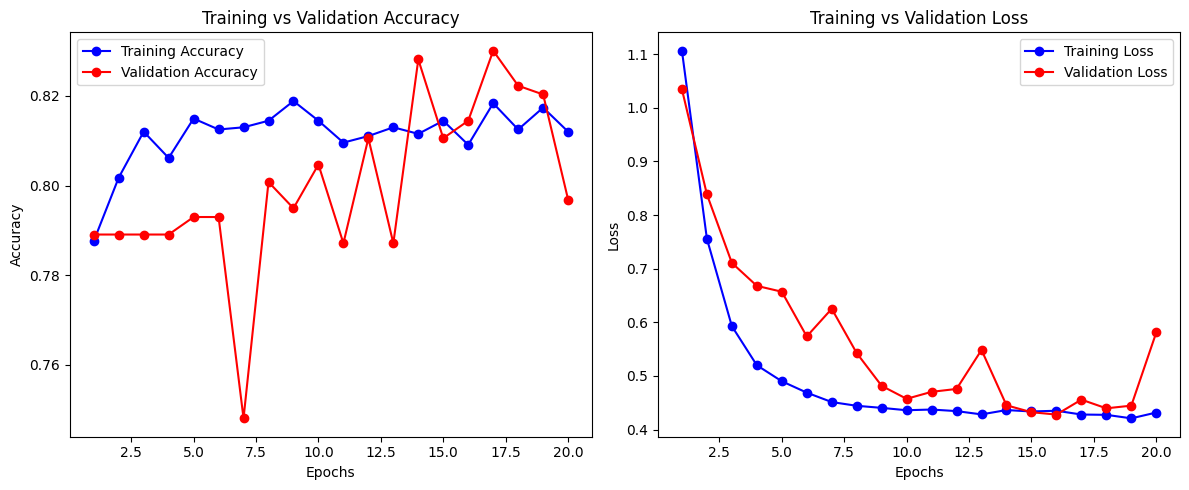

In [62]:
#Visualizing Stage 1 Training Performance
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [56]:
#Confusion Matrix For Stage 1 Binary Classifier
def plot_stage1_confusion_matrix(results_df, save_dir=None):
    '''
    Confusion Matrix for Stage 1 Binary Classifier (Disease_Risk: 0 or 1)

    Parameters:
        results_df (pandas dataframe): The dataframe returned by the evaluate_test_set function which contains the predictions.
    '''
    y_true = results_df['Disease_Risk'].astype(int)
    y_pred = results_df['predicted_risk'].astype(int)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy (0)', 'Unhealthy (1)'])
    disp.plot(cmap='Blues', values_format='d', colorbar=False)
    plt.title("Stage 1: Disease Risk Prediction Confusion Matrix")
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(save_dir)
        plt.close()
    else:
        plt.tight_layout()
        plt.show()

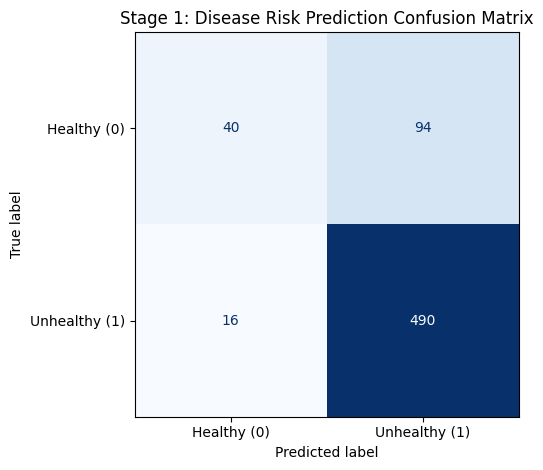

In [63]:
#Plot confusion matrix for Stage 1
plot_stage1_confusion_matrix(results_br)

# Stage 2: Multi-Label Classifier (Binary Relevance) Visualizations

In [69]:
def visualize_predictions(results_df, disease_names, num_samples=5):
    '''
    This function creates image visualizations with model-predicted disease labels for a sample of known-risk cases.
    It allows us to see what the model predicted, and which diseases it thinks are present,
    directly on the images.

    Parameters:
        results_df (pandas dataframe): The dataframe returned by the evaluate_test_set function which contains the predictions.
        disease_names (list): A list of disease labels.
        num_samples (int): Number of random high-risk images to visualize.
    '''
    known_risk_df = results_df[results_df['Disease_Risk'] == 1]
    #Randomly selects up to num_samples from the known-risk cases
    samples = known_risk_df.sample(min(num_samples, len(known_risk_df)))

    for _, row in samples.iterrows():
        img = load_img(row['file_path'], target_size=IMG_SIZE)
        img_array = img_to_array(img) / 255.0
        #Extracts all diseases that were predicted as present for this image
        predicted_diseases = [d for d in disease_names if row.get(f'predicted_{d}', 0) == 1]

        if all(d in row for d in disease_names):
            true_diseases = [d for d in disease_names if row[d] == 1]
        else:
            true_diseases = []

        title = f"Predicted Risk: 1\n"
        title += f"Predicted: {', '.join(predicted_diseases) if predicted_diseases else 'None'}\n"
        title += f"True: {', '.join(true_diseases) if true_diseases else 'Unknown'}"

        plt.figure(figsize=(6,6))
        plt.imshow(img_array)
        plt.axis('off')
        plt.title(title, fontsize=10)
        plt.tight_layout()
        #Show the image directly in the notebook
        plt.show()

    print(f"Displayed {len(samples)} visualizations.")

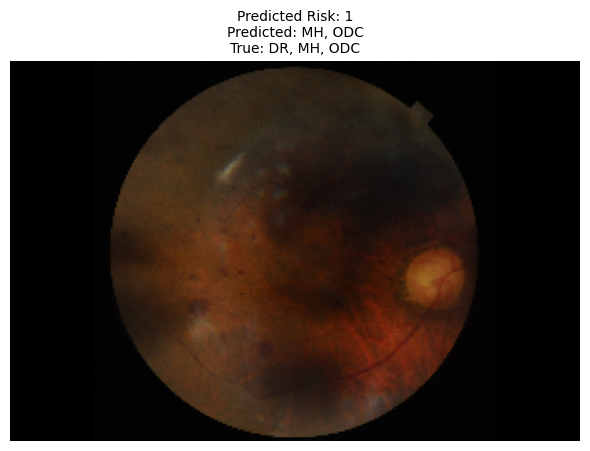

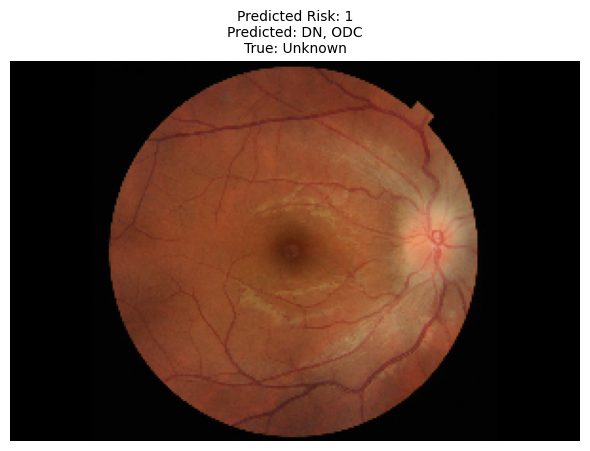

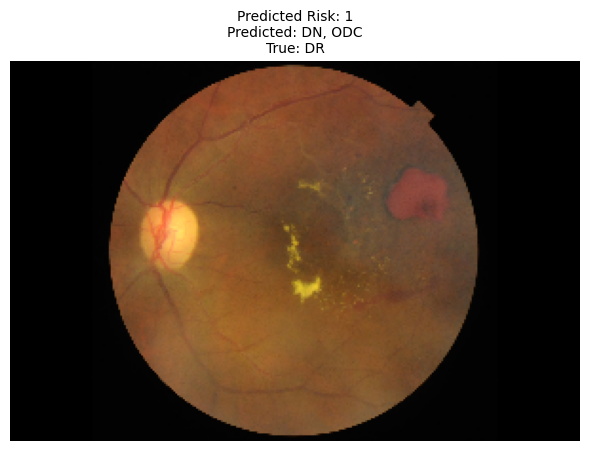

Displayed 3 visualizations.


In [71]:
#Run Visualizations Of Predictions
visualize_predictions(results_br, disease_names, num_samples=3)

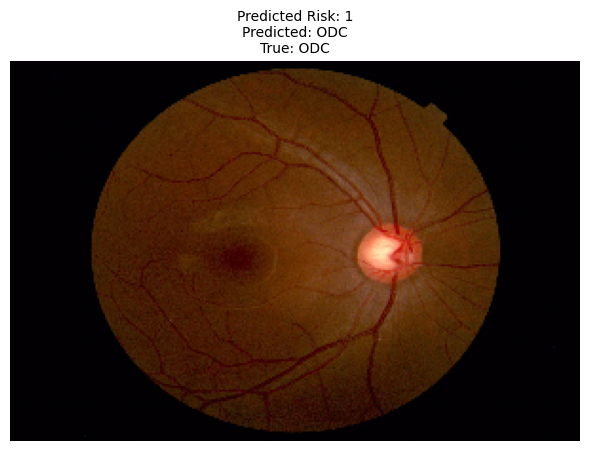

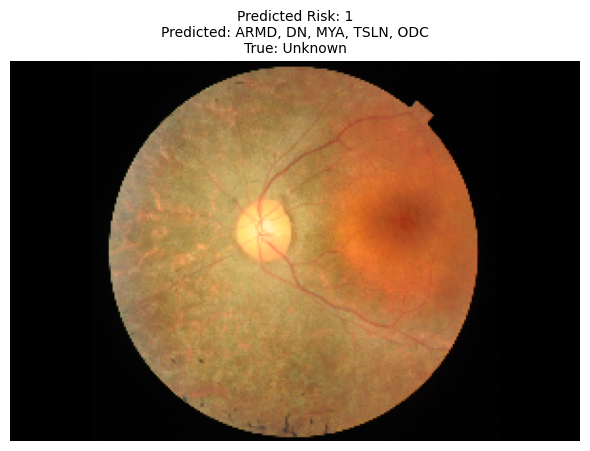

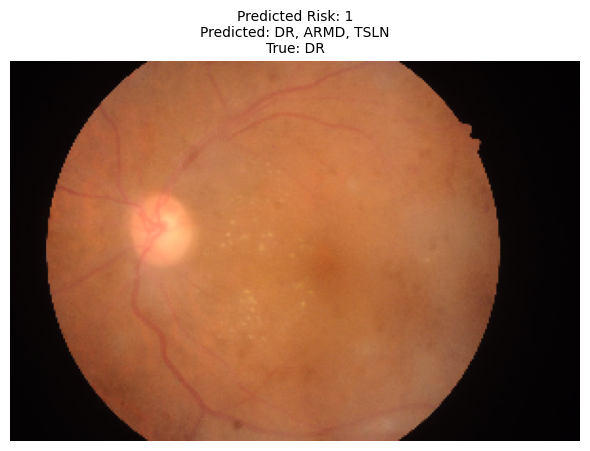

Displayed 3 visualizations.


In [78]:
#Run Visualizations Of Predictions
visualize_predictions(results_br, disease_names, num_samples=3)

# Stage 2: Multi_Label Classifier (Single CNN)



In [79]:
#Defining the model
def build_stage2_model(input_shape, num_labels):
    '''
    This function defines and compiles a Convolutional Neural Network (CNN) for multi-label classification,
    where each input image can be associated with multiple independent labels (i.e., multiple diseases present at once).

    Parameters:
        input_shape (tuple): A tuple specifying the shape of the input images
        num_labels (int): The number of output labels (i.e, the different diseases being predicted).

    Returns:
        model (keras model): The compiled keras model, ready for training with .fit()
    '''
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_labels, activation='sigmoid') #Outputs independent probabilities between 0 and 1 for each label
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [80]:
#Train Stage 2 Model (Multi-label Disease Classifier)
#Only images known to be diseased are used to train the multi-label model (which predicts specific diseases).
#Using curated and upsampled data.
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_upsampled, y2_upsampled, test_size=0.2, random_state=SEED)
train_gen2 = train_datagen.flow(X2_train, y2_train, batch_size=BATCH_SIZE)
val_gen2 = val_datagen.flow(X2_val, y2_val, batch_size=BATCH_SIZE)

model2 = build_stage2_model((IMG_SIZE[0], IMG_SIZE[1], 3), len(disease_names))
history2 = model2.fit(
    train_gen2,
    validation_data=val_gen2,
    epochs=20,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True),
               ModelCheckpoint('model_stage2.keras', save_best_only=True, monitor='val_loss')])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 44s 441ms/step - accuracy: 0.1862 - loss: 0.6478 - val_accuracy: 0.2990 - val_loss: 0.4658
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 400ms/step - accuracy: 0.3023 - loss: 0.4484 - val_accuracy: 0.2863 - val_loss: 0.4326
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 399ms/step - accuracy: 0.3305 - loss: 0.4316 - val_accuracy: 0.2906 - val_loss: 0.4184
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 395ms/step - accuracy: 0.3245 - loss: 0.4198 - val_accuracy: 0.3653 - val_loss: 0.3948
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 367ms/step - accuracy: 0.3780 - loss: 0.3999 - val_accuracy: 0.3822 - val_loss: 0.4006
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 399ms/step - accuracy: 0.3773 - loss: 0.3902 - val_accuracy: 0.3709 - val_loss: 0.3795
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 35s 393ms/step - accuracy: 0.3807 - loss: 0.3800 - val_accuracy: 0.3709 - val_loss: 0.3718
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 33s 371ms/step - accuracy: 0.3682 - loss: 0.3850 - val_accu

In [81]:
#Test Set Evaluation Function
def evaluate_test_set_cnn(df, model1, model2, disease_names, threshold=0.5, save_path=None, verbose=True, zero_division='warn'):
    '''
    This function performs end-to-end evaluation on a test dataset for a two-stage disease prediction model:

            Stage 1: Predicts whether an image indicates high disease risk.

            Stage 2: For known diseased eyes, predicts specific diseases (multi-label classification).

    Lastly, the function also computes metrics, optionally saves the predictions, and returns the full results.

    Parameters:
        df (pandas dataframe): The dataframe containing the test images (i.e., the output of load_dataset)
        model1 (keras model): The keras model for binary classification of Disease_Risk from above
        model2 (keras model): The keras model for the multi-label classification from above
        disease_names (list): A list of disease labels (length = num_labels)
        threshold (float): Probability cutoff for classifying Stage 1 predictions (default: 0.5)
        save_path (str): Optional file path to save predictions as a CSV
        verbose (bool): Print out evaluation metrics for model1 and model2 (default: True)

    Returns:
        final_results (pandas dataframe): The final predictions.
    '''
    X = np.array([preprocess_image(image) for image in df['file_path']])

    #Stage 1 Predictions
    risk_probs = model1.predict(X).flatten()
    df['predicted_risk'] = (risk_probs >= threshold).astype(int)
    df['risk_score'] = risk_probs

    #If ground-truth Disease_Risk labels are available:
    #Computes and prints: Accuracy, Precision, Recall, F1 Score.
    if 'Disease_Risk' in df.columns and verbose:
        y_true = df['Disease_Risk'].values
        y_pred = df['predicted_risk'].values
        print("Stage 1 Metrics:")
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print("Precision:", precision_score(y_true, y_pred, zero_division=zero_division))
        print("Recall:", recall_score(y_true, y_pred, zero_division=zero_division))
        print("F1 Score:", f1_score(y_true, y_pred, zero_division=zero_division))

    #Stage 2 Predictions
    known_risk_df = df[df['Disease_Risk'] == 1].copy()
    X_hr = np.array([preprocess_image(image) for image in known_risk_df['file_path']])

    if len(X_hr) > 0:
        disease_probs = model2.predict(X_hr)
        disease_preds = (disease_probs >= 0.5).astype(int) #Converting the probabilities into binary predictions (per disease).

        for i, disease in enumerate(disease_names):
            known_risk_df[f'predicted_{disease}'] = disease_preds[:, i] #Adds each predicted disease column to the known-risk DataFrame.

        #If all ground-truth disease labels are available:
        #Computes Micro F1 (global average) and Macro F1 (average per disease).
        if all(d in known_risk_df.columns for d in disease_names) and verbose:
            y_true_multi = known_risk_df[disease_names].values
            y_pred_multi = disease_preds
            print("Stage 2 Metrics:")
            print("Subset Accuracy:", accuracy_score(y_true_multi, y_pred_multi))
            print("Micro F1:", f1_score(y_true_multi, y_pred_multi, average='micro', zero_division=zero_division))
            print("Macro F1:", f1_score(y_true_multi, y_pred_multi, average='macro', zero_division=zero_division))

    else:
        for disease in disease_names:
            known_risk_df[f'predicted_{disease}'] = []

    #Merge disease predictions back into the full test DataFrame using the ID column.
    #Any image that wasn’t known risk gets 0s for all diseases:
    final_results = df.merge(
        known_risk_df[['ID'] + [f'predicted_{d}' for d in disease_names]],
        on='ID', how='left')
    for d in disease_names:
        final_results[f'predicted_{d}'] = final_results[f'predicted_{d}'].fillna(0).astype(int)

    #Saving the final DataFrame to a CSV file if save_path is specified.
    if save_path:
        final_results.to_csv(save_path, index=False)
        if verbose:
            print(f"Saved predictions to {save_path}")

    #Returning the DataFrame with predictions and scores, including:
    #risk_score, predicted_risk, predicted_eye_disease1, predicted_eye_disease2, etc.
    return final_results

In [83]:
#Run Test Evaluation
from tensorflow.keras.models import load_model
results_cnn = evaluate_test_set_cnn(
    df=test_df,
    model1=model1,
    model2=model2,
    disease_names=disease_names,
    threshold=0.5,
    save_path="predicted_test_results_cnn.csv",
    zero_division=0)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Stage 1 Metrics:
Accuracy: 0.828125
Precision: 0.839041095890411
Recall: 0.9683794466403162
F1 Score: 0.8990825688073395
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
Stage 2 Metrics:
Subset Accuracy: 0.391304347826087
Micro F1: 0.4305381727158949
Macro F1: 0.37066414094925115
Saved predictions to predicted_test_results_cnn.csv


# Stage 2: Multi_Label Classifier (Single CNN) Visualizations

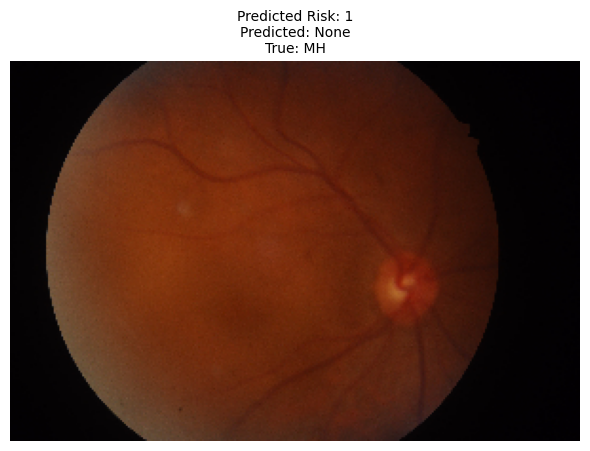

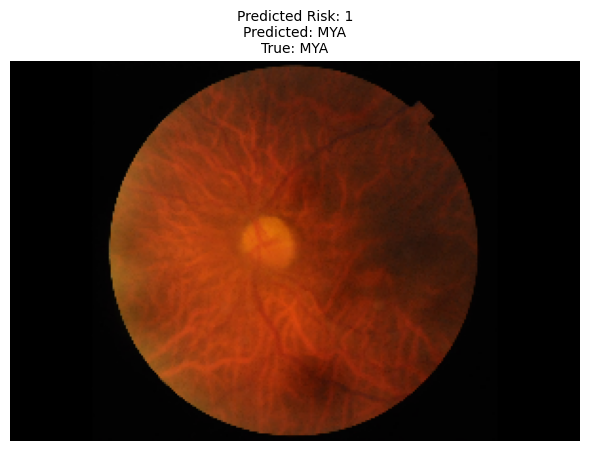

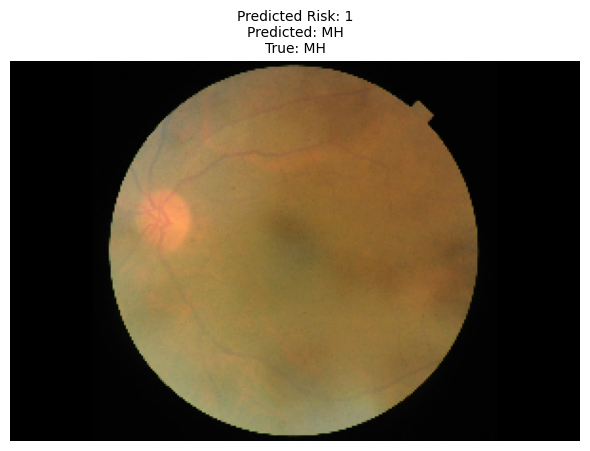

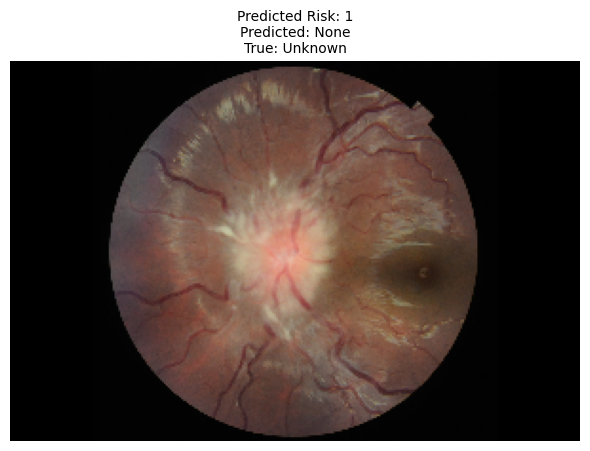

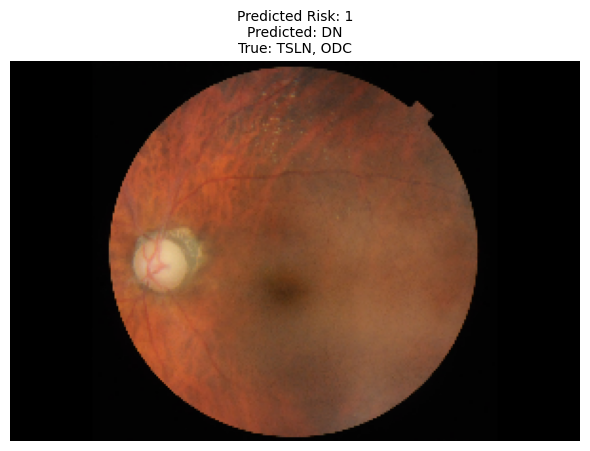

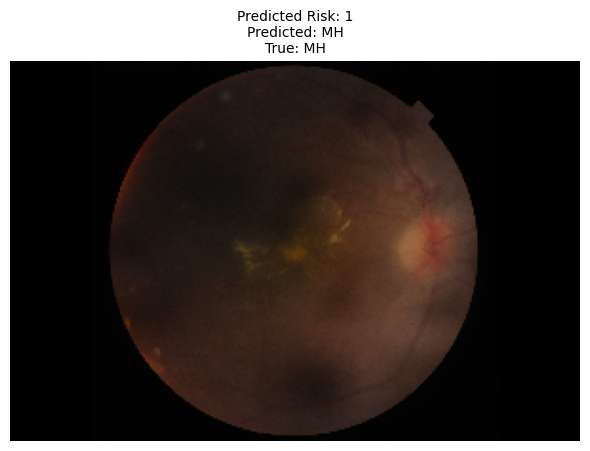

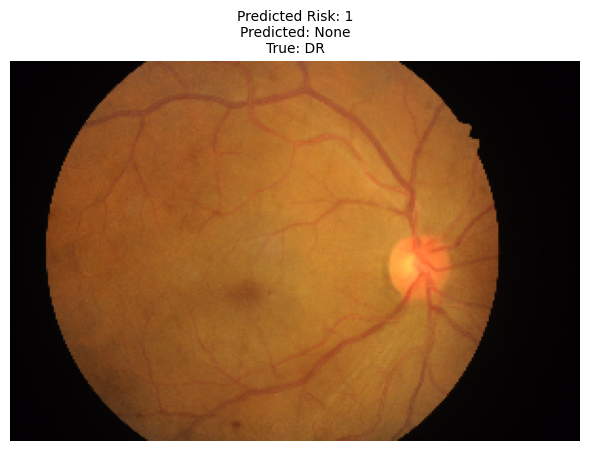

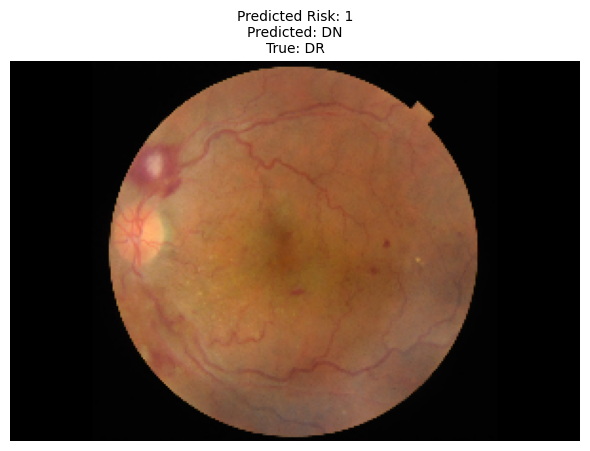

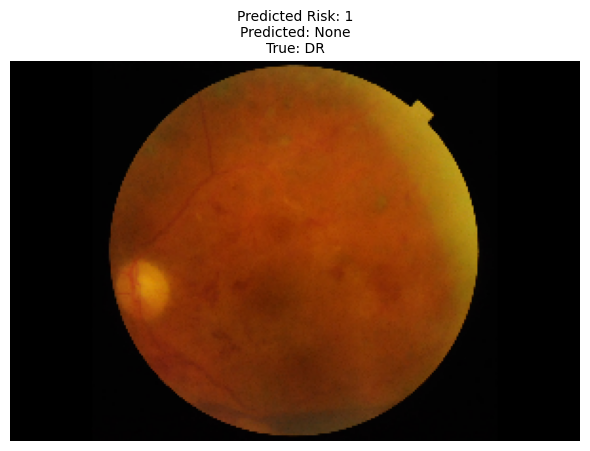

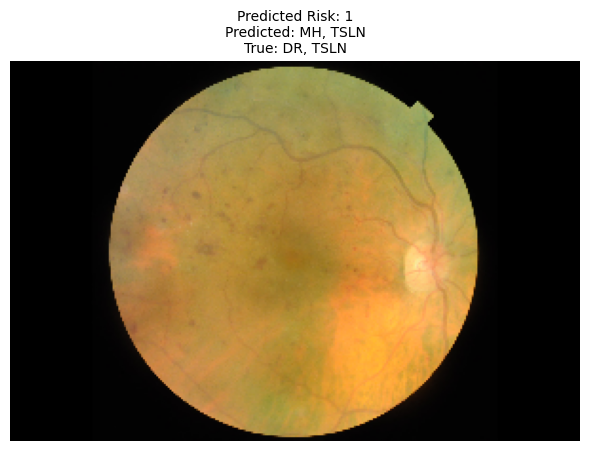

Displayed 10 visualizations.


In [84]:
#Run Visualizations Of Predictions
visualize_predictions(results_cnn, disease_names, num_samples=10)

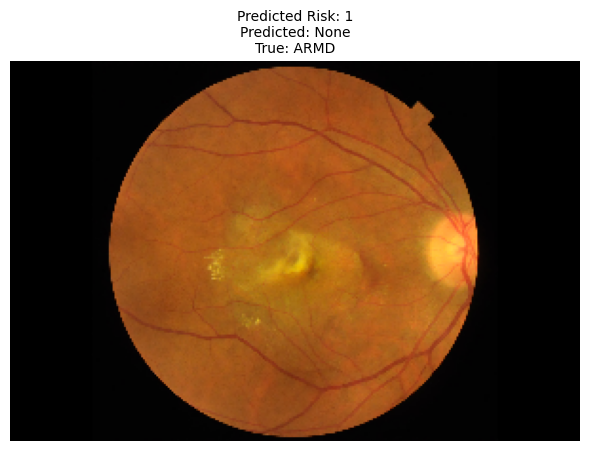

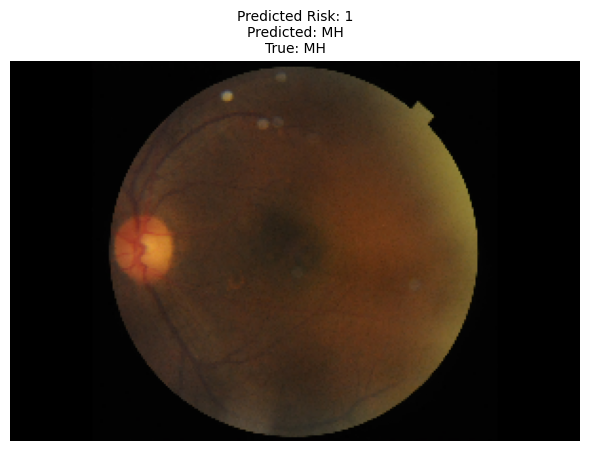

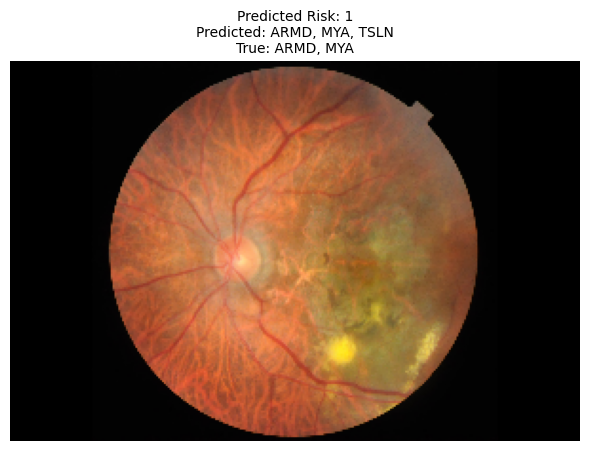

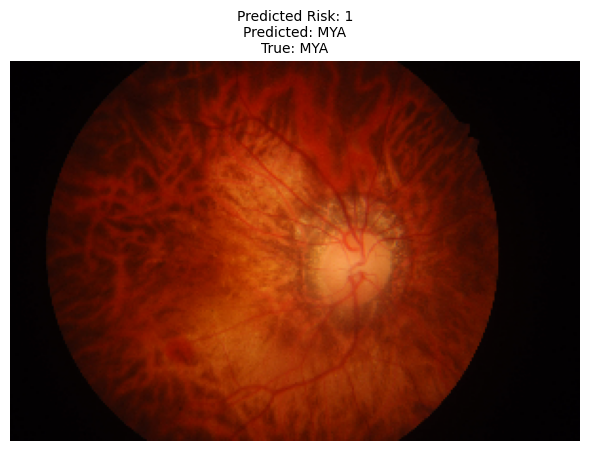

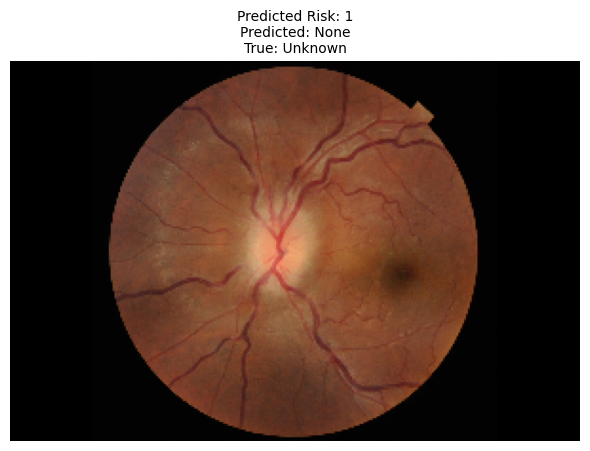

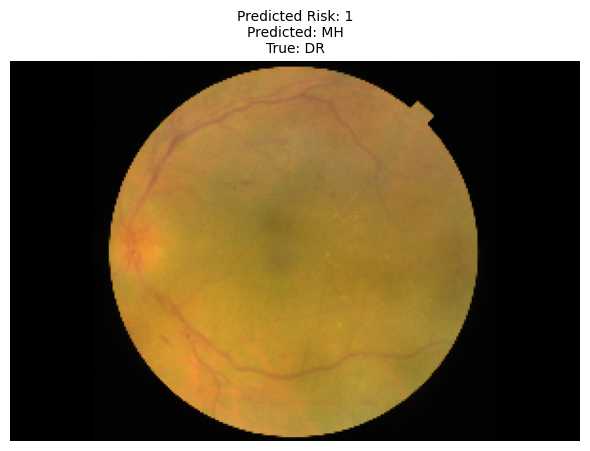

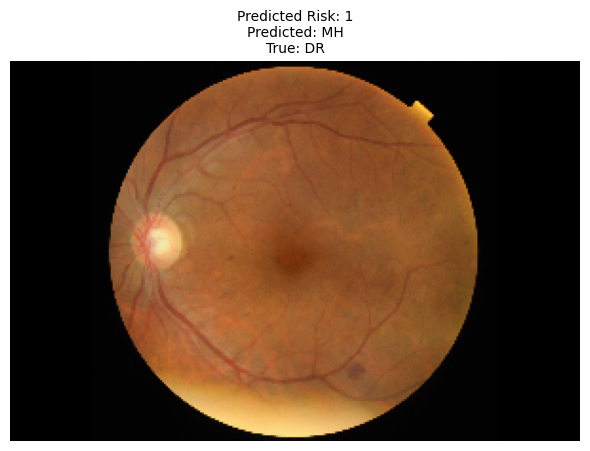

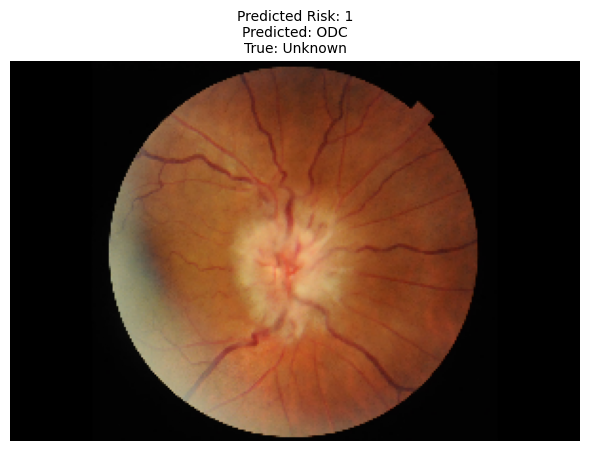

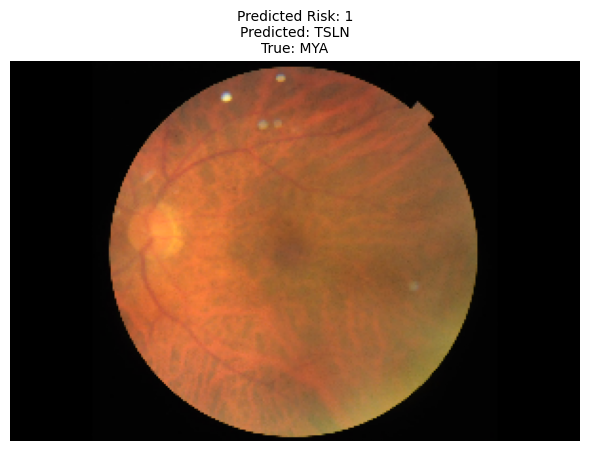

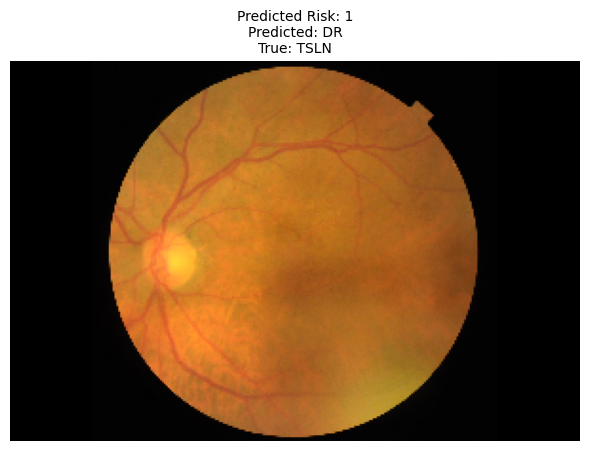

Displayed 10 visualizations.


In [92]:
#Run Visualizations Of Predictions
visualize_predictions(results_cnn, disease_names, num_samples=10)